#  Прогнозирование заказов такси

**Описание проекта**

Компания такси собирается оптимизировать работу водителей в часы пик. Для этой цели необходимо:
* Спрогнозировать количество заказов такси на следующий час.
* Построить модель для такого предсказания.
* Значение метрики *RMSE* на тестовой выборке должно быть не больше `48`.

**Цель:** Обучить различные модели для прогнозирования количества заказов в такси на следующий час и выбрать из них ту, которая обеспечит лучший результат.


**Задачи:**
1. Загрузить и проанализировать данные.
2. Подготовить данные к обучению моделей.
3. Обучить модели на различных алгоритмах и проверить их качество.


**Источник данных:** Данные находятся в файле `taxi.csv`.


**План выполнения работы:**
1. Загрузить данные и выполнить их ресемплирование к периоду один час.
    * 1.1 Загрузка исходных данных
    * 1.2 Сортировка и ресемплирование
    * 1.3 Выводы
2. Проанализировать данные.
    * 2.1 Выявление трендов
    * 2.2 Дневные графики (D1)
    * 2.3 4-часовые графики (H4)
    * 2.4 Часовые графики (H1)
    * 2.5 Создание признаков на основе часовых, 4-часовых и дневных данных
    * 2.6 Формирование единого датасета
    * 2.7 Выводы
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
    * 3.1 Формирование обучающей и тестовой выборок
    * 3.2 Определение метрики для обучения
    * 3.3 *Сonstant*-модель
    * 3.4 Линейная регрессия
    * 3.5 *Ridge*-регрессия
    * 3.6 *Lasso*-регрессия
    * 3.7 *ElasticNet*-регрессия
    * 3.8 Случайный лес
    * 3.9 *CatBoostRegressor*
    * 3.10 Сравнительный анализ моделей
    * 3.11 Выводы по обучению моделей
4. Сформулировать общие выводы.

## Загрузка и анализ данных

### Загрузка исходных данных

Подключим необходимые для работы библиотеки:
* `pandas` - для работы с таблицами;
* `numpy` - для операций над массивами;
* `seaborn` - для визуализации данных;
* `sklearn` - инструменты машинного обучения (модели регрессии, метрики для исследования качества моделей, разделение данных, предобработка данных и т.д.).

In [1]:
import pandas as pd
import numpy as np
import datetime

from statsmodels.tsa.seasonal import seasonal_decompose

# обучение моделей
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor

# метрики
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from catboost import CatBoostRegressor

# визуализация
import matplotlib.pyplot as plt
import seaborn as sns

Зададим начальное значение генератора псевдослучайных чисел для вопроизводимости полученных в исследовании результатов.

In [2]:
# начальное значение генератора псевдослучайных чисел
RND = 123

Исходные данные представлены в одном файле. Загрузим и проведём их предварительную оценку. Посмотрим на общий вид табличных данных, сводную информацию, проверим количество пропущенных значений и наличие дубликатов в исследуемой таблице из файла `taxi.csv`.

In [3]:
# чтение файла taxi.csv на два случая (из директории Яндекса и с локального окружения) 
df = pd.read_csv('/datasets/taxi.csv', parse_dates=['datetime'])

In [4]:
# вывод первых строк таблицы изучаемых данных
df.head(10)

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
5,2018-03-01 00:50:00,21
6,2018-03-01 01:00:00,7
7,2018-03-01 01:10:00,5
8,2018-03-01 01:20:00,17
9,2018-03-01 01:30:00,12


In [5]:
# просмотр сводной информации о данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [6]:
# подсчёт количества пропущенных значений
df.isna().sum()

datetime      0
num_orders    0
dtype: int64

In [7]:
# подсчёт количества дубликатов
df.duplicated().sum()

0

> * Данные успешно загружены из файла. Таблица содержит `26496` записей с данными о количестве заказов в такси в виде двух признаков:
>     * дата и время
>     * количество заказов
> * Пропусков и дубликатов в предоставленных для исследования данных нет.
> * Время разбито на 10-минутные интервалы. Так как по условиям задачи требуется спрогнозировать количество заказов на следующий час, то целесообразно провести ресемплирование данных к часовому временному интервалу.

### Предобработка данных

При работе с временными рядами логичным действием является использование признака времени в качестве индексов таблицы.

In [8]:
# назначение признака времени в качестве индексов таблицы
df = df.set_index('datetime')
df.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


В работе с временными рядами также важно соблюдение последовательности объектов от более старых к более новым. Поэтому, произведём сортировку значений по индексу в порядке возрастания после чего проверим монотонность значений индекса.

In [9]:
# сортировка индексов по возрастанию
df = df.sort_index(ascending=True)
df.index.is_monotonic

True

Так как предстоит семплирование данных, для проверки корректности произведённых изменений на исходных данных определим общее количество заказов по всему периоду данных.

In [10]:
# проверка общего количества заказов в данных
print('-' * 95)
print('| {: <80}|'.format(f'Общее количество заказов в исходных данных:'), end='')
print('{: >10d} |'.format(df['num_orders'].sum()))
print('-' * 95)

-----------------------------------------------------------------------------------------------
| Общее количество заказов в исходных данных:                                     |    372811 |
-----------------------------------------------------------------------------------------------


Общее количество заказов в исходных данных составляет `372811`.

Посмотрим на сводную информацию о таблице после произведённых изменений.

In [11]:
# просмотр сводной информации о данных
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Судя по начальному и конечному индексам, в таблице представлены данные за период с `1 марта 2018 года` по `31 августа 2018` года (`6` месяцев).

В данных остался один признак - количество заказов за 10-минутный период. Поскольку по условиям задания поставлена задача предсказания количества заказов на 1 час вперёд, выполняем ресемплирование данных к часовому периоду в индексах.

In [12]:
# ресемплирование данных к часовому периоду в индексах
df = df.resample('1H').sum()

Проверим, что семплирование данных произошло корректно. Для этого ещё раз определим временной промежуток данных, а также сравним общее количество заказов и количество записей в таблице.

In [13]:
# определение временного промежутка данных после семплирования
print('-' * 110)
print('| {: <60}|'.format(f'Временной промежуток семплированных данных:'), end='')
print('{: >45} |'.format(f'{str(df.index.min())} - {str(df.index.max())}'))
print('-' * 110)

--------------------------------------------------------------------------------------------------------------
| Временной промежуток семплированных данных:                 |    2018-03-01 00:00:00 - 2018-08-31 23:00:00 |
--------------------------------------------------------------------------------------------------------------


In [14]:
# проверка общего количества заказов в данных после семплирования
print('-' * 95)
print('| {: <80}|'.format(f'Общее количество заказов в исходных данных:'), end='')
print('{: >10d} |'.format(df['num_orders'].sum()))
print('-' * 95)

-----------------------------------------------------------------------------------------------
| Общее количество заказов в исходных данных:                                     |    372811 |
-----------------------------------------------------------------------------------------------


In [15]:
# проверка общего количества заказов в данных после семплирования
print('-' * 95)
print('| {: <80}|'.format(f'Общее количество объектов в данных после семплирования:'), end='')
print('{: >10d} |'.format(df.shape[0]))
print('-' * 95)

-----------------------------------------------------------------------------------------------
| Общее количество объектов в данных после семплирования:                         |      4416 |
-----------------------------------------------------------------------------------------------


После произведённого семплирования общее количество заказов и временной промежуток данных не изменились. Количество объектов в таблице сократилось с `26496` до `4416`, то есть ровно в 6 раз. Из этого можно сделать вывод, что семплирование выполнено корректно.

Выделим обучающую и тестовую выборки. В соответствии с требованиями к заданию объём теста должен составлять 10%. Разделение будем производить без перемешивания. Тестовые данные в таком случае будут находиться в конце рассматриваемого периода.

In [16]:
# разделение данных на обучающую и тестовую выборки
df_train, df_test = train_test_split(df, shuffle=False, test_size=0.1)

Посмотрим на сводную информацию о полученных обучающей и тестовой выборках.

In [17]:
# просмотр сводной информации о данных в обучающей выборке
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3974 entries, 2018-03-01 00:00:00 to 2018-08-13 13:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  3974 non-null   int64
dtypes: int64(1)
memory usage: 62.1 KB


In [18]:
# просмотр сводной информации о данных в тестовой выборке
df_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 442 entries, 2018-08-13 14:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  442 non-null    int64
dtypes: int64(1)
memory usage: 6.9 KB


Границей разделения стал индекс `2018-08-13 14:00:00`, то есть середина дня 13 августа. Целесообразно незначительно сдвинуть границу разделения на конец дня, чтобы данные были кратны всем периодам, которые будут использованы в дальнейшем - дневному `D1` и часовому `H1`.

Для удобства разделения создадим вспомогательную функцию *split_train_test()*.

In [19]:
# функция для разделения исходного датафрейма на обучающую и тестовую выборки по дате
def split_train_test(df, df_train_end='2018-08-13 23:00:00', df_test_start='2018-08-14 00:00:00'):
    """
    input: df (pandas.DataFrame)  - исходный датафрейм для разделения данных на обучающую и тестовую выборки
    output: df_train_end (str)    - конечная граница для обучающего набора данных
            df_test_start (str)   - стартовая граница для тестового набора данных
    description: Функция принимает датафрейм и разбивает его на обучающую и тестовую выборки по указанной дате
    """
    df_train = df[:df_train_end]
    df_test = df[df_test_start:]  
    
    return df_train, df_test

In [20]:
# разделение данных на обучающую и тестовую выборки по окончанию дня 13 августа 2018 года
df_train, df_test = split_train_test(df)

### Выводы по анализу данных

> * Полученные в файле `taxi.csv` данные о количестве заказов в такси содержат `26495` записей, пропуски и дубликаты в данных отсуствуют.
> * Данные представлены в виде двух признаков:
>  - дата и время `datetime`
>  - количество заказов `num_orders`
> * Изначально время в данных разбито на 10-минутные интервалы.
> * Судя по начальному и конечному индексам в таблице представлены данные за период с `1 марта 2018 года` по `31 августа 2018` года (`6` месяцев).
> * Для работы с данными как с временными рядами в качестве индексов использован признак времени. Данные проверены на монотонность и отсортированы по возрастанию.
> * В соотвествии с уловиями задания проведено семплирование данных к 1-часовому временному промежутку. Судя по общему количеству заказов и оставшемуся неизменным временному промежутку, семплирование произведено корректно. Потерь данных нет.
> * Количество объектов в таблице после семплирования сократилось с `26496` до `4416`, то есть ровно в `6` раз.
> * Данные разделены на обучающую и тестовую выборки без перемешивания (тестовые данные находятся в конце рассматриваемого периода). Согласно требований к заданию для тестирования выделено 10% от общего количества данных.
> * Так как граница разделения при использовании метода *train_test_split* из библиотеки *sklearn* выпала на середину дня дня `13 августа`, она была сдвинута вручную на конец этого же дня, чтобы данные были кратны всем периодам, которые будут использованы в дальнейшем - дневному `D1` и часовому `H1`.

## Анализ обучающей выборки и подготовка данных

### Поиск трендов

Проведём общую оценку данных обучающей выборки. Визуализируем на линейном графике данные по количеству заказов за весь период данных.

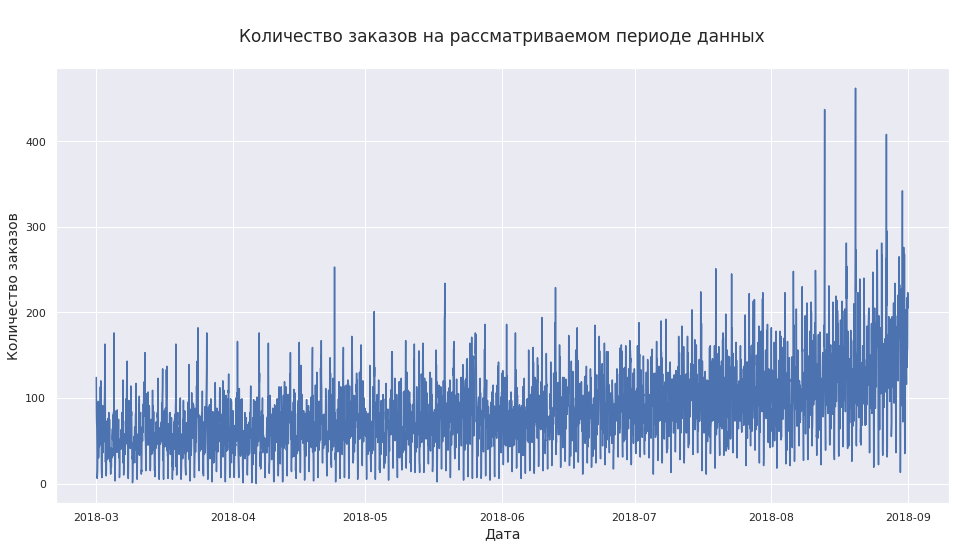

In [21]:
# визуализация количества заказов на рассматриваемом периоде данных
sns.set()
plt.figure(figsize=(16, 8))
ax = sns.lineplot(data=df, x=df.index, y='num_orders')
ax.set_title('\nКоличество заказов на рассматриваемом периоде данных\n', fontsize=17)
ax.set_xlabel('Дата', fontsize=14)
ax.set_ylabel('Количество заказов', fontsize=14)
plt.show();

> * На графике заметен некоторый тренд, заключающийся в увеличении количества заказов ближе к концу рассматриваемого периода.
> * Так как значения на графике плотно сгруппированы по временной шкале, проведём более подробный анализ обучающей выборки. Для этого выполним дополнительное семплирование данных по дням с целью дополнительного выявления трендов и сезонности в исследуемых данных.

### Дневные графики (`D1`)

Проведём семплирование данных до периода в 1 день. Полученные данные сохраним в отдельном датафрейме и добавим к данным два признака: порядковый номер дня `day` и номер дня недели `dayofweek`.

In [22]:
# семплирование данных до периода D1, сохранение в отдельный датафрейм и просмотр первых строк данного датафрейма
df_D1 = df_train.resample('1D').sum()
df_D1['day'] = df_D1.index.day
df_D1['dayofweek'] = df_D1.index.dayofweek

df_D1.head(5)

,num_orders,day,dayofweek
datetime,,,
2018-03-01,1364,1,3
2018-03-02,1506,2,4
2018-03-03,1290,3,5
2018-03-04,1141,4,6
2018-03-05,1259,5,0


Разложим полученные данные на три составляющие: тренд, сезонность и остатки. Для лучшей визуализации тренда проведём сглаживания колебаний на графике простой скользящей средней *simple moving average* (розовая линия). С целью повышения удобства построения графиков и исключения дублирования кода в однотипных операциях создадим вспомогательную функцию *show_decomposed_charts()*. 

In [23]:
# функция отображения тренда, сезонности и остатков для исследуемых данных
def show_decomposed_charts(decomposed, sma_period=20):
    """
    input: decomposed (DecomposeResult) - декомпозированные с помощью метода seasonal_decompose библиотеки
                                          statsmodels данные
           sma_period (int)             - период скользящей средней для сглаживания графика тренда
    output: None
    description: Функция принимает input параметры и строит графики тренда, сезонности и остатков для исследуемых данных
    """
    print()
    plt.style.use('ggplot')

    plt.figure(figsize=(13, 15))
    plt.subplot(311)
    decomposed.trend.plot(ax=plt.gca(), color='#1F77B4')
    decomposed.trend.rolling(sma_period).mean().shift().plot(ax=plt.gca(), color='#E377C2')
    plt.title('Тренд')
    plt.xlabel('Дата')
    
    plt.subplot(312)
    decomposed.seasonal.plot(ax=plt.gca(), color='#1F77B4')
    plt.title('Сезонность')
    plt.xlabel('Дата')
    
    plt.subplot(313)
    decomposed.resid.plot(ax=plt.gca(), color='#1F77B4')
    plt.title('Остатки')
    plt.xlabel('Дата')
    
    plt.tight_layout()
    
    return None

Воспользуемся созданой функцией *show_decomposed_charts()* и построим графики тренда, сезонности и остатков для дневных графиков.

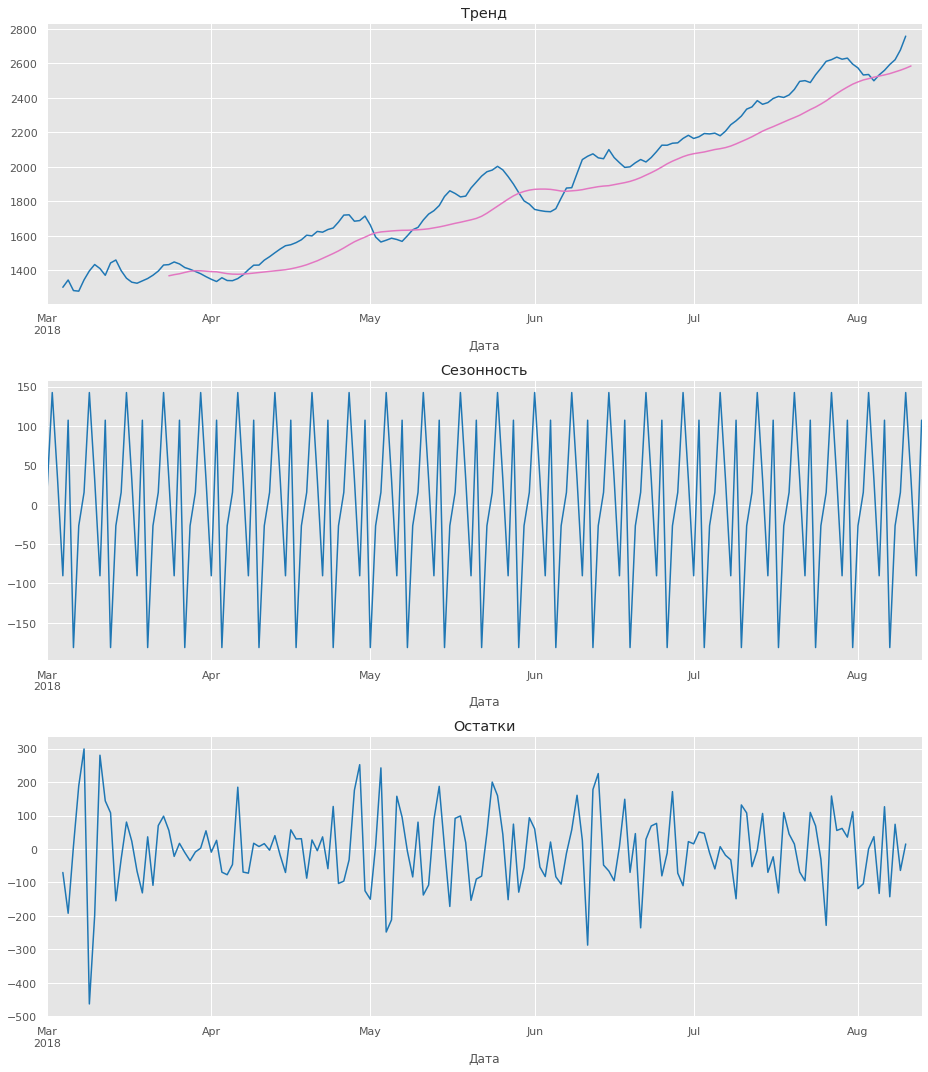

In [24]:
# декомпозиция данных и построение графиков тренда, сезонности и остатков
decomposed_D1 = seasonal_decompose(df_D1['num_orders'])
show_decomposed_charts(decomposed_D1)

На дневных графиках можно чётко выделить восходящий тренд, а также выраженные периоды сезонности. Для более детального изучения сезонности рассмотрим её в более узком временном интервале. Создадим для этой цели новую вспомогательную функцию *show_seasonal_chart()*.

In [25]:
# функция для детального изучения сезонности путём рассмотрения её в более узком временном интервале
def show_seasonal_chart(decomposed, start_date='2018-07-01', end_date='2018-08-01', frame='D1'):
    """
    input: decomposed (DecomposeResult) - декомпозированные с помощью метода seasonal_decompose библиотеки
                                          statsmodels данные
           start_date (str)             - начальная дата изучаемого периода
           end_date   (str)             - конечная дата изучаемого периода
           frame      (str)             - периодичность исследуемых данных (D1, H4, H1)
    output: None
    description: Функция принимает input параметры и строит детализированный график сезонности с характерными
                 границами в виде вертикальных линий. Для D1 графиков линии будут соотвествовать началу недели 
                 (понедельнику). Для H4 и H1 - началу нового дня в 00:00.
    """
    print()
    plt.style.use('ggplot')
    
    plt.figure(figsize=(13, 6))
    decomposed.seasonal[start_date:end_date].plot(ax=plt.gca(), color='#1F77B4')
    plt.title('Сезонность')
    plt.xlabel('Дата')
    
    # вертикальные линии для графиков D1
    if frame == 'D1':
        for t in df_D1.loc[start_date:end_date].query('dayofweek==0').index:
            plt.axvline(x=t, color='#E377C2', linestyle='--')
    
    # вертикальные линии для графиков H4 и H1
    if frame == 'H1':
        for t in df.loc[start_date:end_date].index:
            if str(t)[-8:] == '00:00:00':
                plt.axvline(x=t, color='#E377C2', linestyle='--')
        
    plt.tight_layout()

Воспользуемся функцией *show_seasonal_chart()* для более детального анализа сезонности на дневных графиках в период с `2018-07-01` по `2018-08-01`.

Вертикальные розовые линии - начало новой недели в понедельник в 00:00.

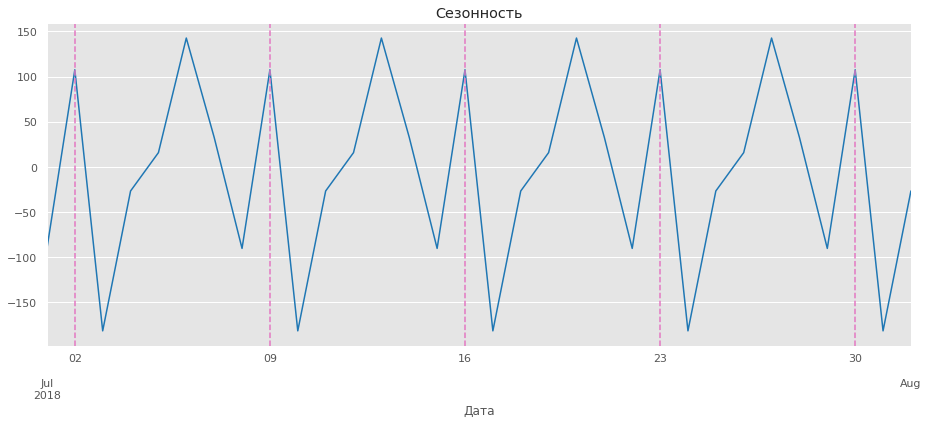

In [26]:
# отображение графика сезонности в выбранный период
show_seasonal_chart(decomposed_D1)

На графике видны ярко выраженные сезонные периоды продолжительностью 7 дней с минимальными значениями в воскресенье и вторник и пиками в понедельник и пятницу.

> * Выявленные закономерности позволяют сделать вывод о наличии недельной сезонности в исследуемых данных и о возможной значимости признака в виде дня недели для прогноза количества заказов такси на следующий час.

### Часовые графики (`H1`)

Аналогичным образом на часовых графиках выделим сезонность и тренд и подробнее рассмотрим график сезонной компоненты. Семплирование в данном случае не потребуется так как данные у нас и так уже соответствуют часовому периоду. Необходимо только выполнить для них декомпозицию.

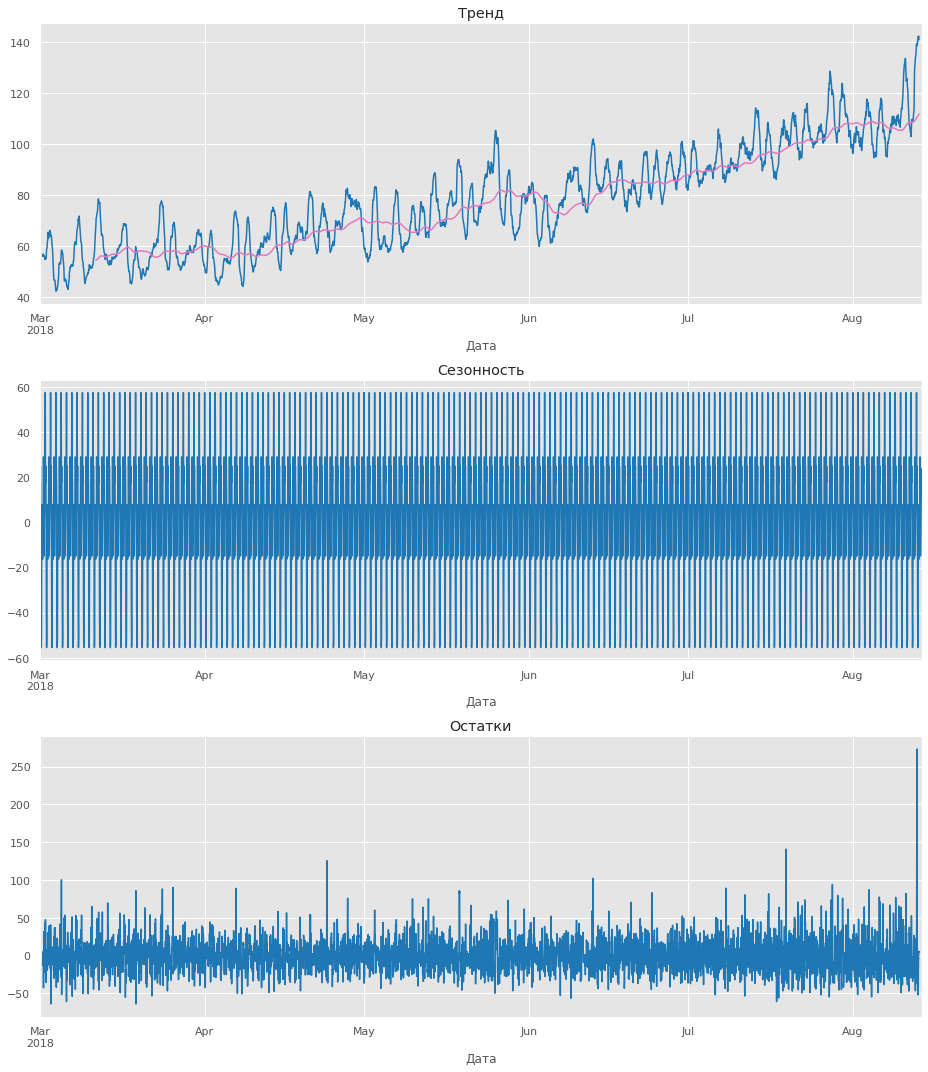

In [27]:
# декомпозиция данных и построение графиков тренда, сезонности и остатков
decomposed_H1 = seasonal_decompose(df_train['num_orders'])
show_decomposed_charts(decomposed_H1, sma_period=240)

Воспользуемся функцией *show_seasonal_chart()* для более детального анализа сезонности на часовых графиках в период с `2018-07-01` по `2018-07-07`.

Вертикальные розовые линии - начало нового дня в 00:00.

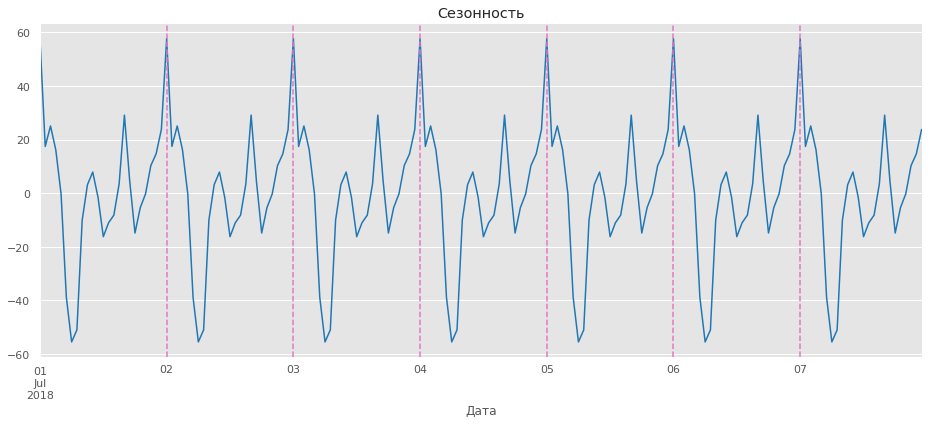

In [28]:
# отображение графика сезонности в выбранный период
show_seasonal_chart(decomposed_H1, start_date='2018-07-01', end_date='2018-07-07', frame='H1')

> * Часовые сезонные циклы также достаточно хорошо выделены:
>  - сутки начинаются с пикового значения объёма заказов в 0 часов;
>  - далее следует резкое падение до минимума в районе 6 часов утра;
>  - рост объёма заказов с 7 часов и боковой тренд в рабочие часы (с 8 до 18);
>  - плавный рост до пикового значения с 18 до 0 часов.
>  
> * Целесообразно рассмотреть следующие возможные признаки для модели:
>  - часовой объём заказов с лагом в 24 часа;
>  - часовой объём заказов 1 и 2 часа назад;
>  - скользящая средняя по 12 и 24 часам - со сдвигом в 1 час вперёд для исключения утечек данных (target leakage).

### Создание дополнительных признаков на основе данных часовой и дневной периодичности

Обратимся к полному набору данных, который ранее был семплирован к периодичности, соотвествующей часовому графику и на его основе создадим дневной график.

In [29]:
# семплирование датасета с часовой периодичностью данных для получения на его основе датасетов с 4-часовым и дневным 
# периодами
df_D1 = df.resample('1D').sum()

Создадим признаки - компоненты даты (номер дня недели, порядковый номер месяца, порядковый номер дня месяца и номер часа), которые будут в последующем использованы для объединения часовых данных с данными по дням. Для этого создадим вспомогательную функцию *make_date_features()*.

In [30]:
# функция для создания дополнительных признаков
def make_date_features(data):
    """
    input: data (pandas.DataFrame) - датафрейм, в котором будут созданы дополнительные признаки
    output: None
    description: Функция принимает на вход датафрейм и добавляет к нему следующие признаки: номер дня недели, 
                 порядковый номер месяца, порядковый номер дня месяца и номер часа
    """
    data['dayofweek'] = data.index.dayofweek
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['hour'] = data.index.hour

In [31]:
# применение функции make_date_features к соотвествующим датафреймам 
make_date_features(df)
make_date_features(df_D1)

Далее выполним генерацию признаков для каждого из рассматриваемых периодов (часового и дневного).

#### Создание дополнительных признаков для часовых данных

Сформируем признаки на основе часовых данных.

In [32]:
# формирование признаков на основе ближайших периодов часовых графиков
for lag in (1, 2, 24):
    df[f'H1_lag_{lag}'] = df['num_orders'].shift(lag)

In [33]:
# формирование признаков на основе скользящих средних для часовых графиков
df['H1_sma_12'] = df['num_orders'].shift(1).rolling(12).mean()
df['H1_sma_24'] = df['num_orders'].shift(1).rolling(24).mean()
df.tail(5)

,num_orders,dayofweek,month,day,hour,H1_lag_1,H1_lag_2,H1_lag_24,H1_sma_12,H1_sma_24
datetime,,,,,,,,,,
2018-08-31 19:00:00,136,4,8,31,19,207.0,217.0,72.0,163.416667,164.875000
2018-08-31 20:00:00,154,4,8,31,20,136.0,207.0,142.0,170.916667,167.541667
2018-08-31 21:00:00,159,4,8,31,21,154.0,136.0,198.0,168.583333,168.041667
2018-08-31 22:00:00,223,4,8,31,22,159.0,154.0,158.0,164.916667,166.416667
2018-08-31 23:00:00,205,4,8,31,23,223.0,159.0,246.0,167.583333,169.125000


> * Все необходимые предварительные расчёты произведены, полученные данные сохранены в таблицах соотвествующих периодов. Теперь необходимо все сгенерированные признаки объединить в единый набор данных, который будет использован для обучения различных моделей.

### Формирование объединённого датасета

Объединим в одной таблице исходные часовые данные и подготовленную статистику по дневному графику.

In [34]:
# объединение с данными дневного периода
df_merged = df.reset_index().merge(df_D1, on=['month', 'day'], how='inner')

In [35]:
# просмотр первых строк объединённой таблицы
df_merged.head(5)

,datetime,num_orders_x,dayofweek_x,month,day,hour_x,H1_lag_1,H1_lag_2,H1_lag_24,H1_sma_12,H1_sma_24,num_orders_y,dayofweek_y,hour_y
0,2018-03-01 00:00:00,124,3,3,1,0,NaN,NaN,NaN,NaN,NaN,1364,3,0
1,2018-03-01 01:00:00,85,3,3,1,1,124.0,NaN,NaN,NaN,NaN,1364,3,0
2,2018-03-01 02:00:00,71,3,3,1,2,85.0,124.0,NaN,NaN,NaN,1364,3,0
3,2018-03-01 03:00:00,66,3,3,1,3,71.0,85.0,NaN,NaN,NaN,1364,3,0
4,2018-03-01 04:00:00,43,3,3,1,4,66.0,71.0,NaN,NaN,NaN,1364,3,0


Для последующего объединения с 4-часовыми данными удалим столбцы с постфиком `_y`, образовавшиеся после слияния таблиц. Данные с постфиком `_x` переименуем, возвратив им исходные названия.

In [36]:
# удаление столбцов с постфиксом _y и переименование с _x
df_merged = df_merged.drop([col for col in df_merged.columns if "_y" in col], axis=1)
df_merged = df_merged.rename(columns=lambda x: x.replace('_x', ''))

Удалим строки с пропущенными значениями, для расчёта которых не нашлось необходимого количества данных, а также возвратим использование атрибута `datetime` в качестве индексов.

In [37]:
# финальные преобразования объединённого датасета
df_merged = df_merged.dropna()
df_merged = df_merged.set_index('datetime')
df_merged = df_merged.drop(columns=['month', 'day'])
df_merged.head(5)

,num_orders,dayofweek,hour,H1_lag_1,H1_lag_2,H1_lag_24,H1_sma_12,H1_sma_24
datetime,,,,,,,,
2018-03-02 00:00:00,90,4,0,58.0,113.0,124.0,56.583333,56.833333
2018-03-02 01:00:00,120,4,1,90.0,58.0,85.0,61.583333,55.416667
2018-03-02 02:00:00,75,4,2,120.0,90.0,71.0,68.916667,56.875000
2018-03-02 03:00:00,64,4,3,75.0,120.0,66.0,71.166667,57.041667
2018-03-02 04:00:00,20,4,4,64.0,75.0,43.0,71.000000,56.958333


Посмотрим на сводную информацию о полученном объединённом датасете.

In [38]:
# просмотр сводной информации об итоговом датафрейме
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4392 entries, 2018-03-02 00:00:00 to 2018-08-31 23:00:00
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   num_orders  4392 non-null   int64  
 1   dayofweek   4392 non-null   int64  
 2   hour        4392 non-null   int64  
 3   H1_lag_1    4392 non-null   float64
 4   H1_lag_2    4392 non-null   float64
 5   H1_lag_24   4392 non-null   float64
 6   H1_sma_12   4392 non-null   float64
 7   H1_sma_24   4392 non-null   float64
dtypes: float64(5), int64(3)
memory usage: 308.8 KB


### Выводы по анализу обучающей выборки и подготовке данных

> * Данные с часовым периодом `H1` дополнительно семплированы для получения временного ряда с дневной (`D1`) периодичностью.
> * На основе данных часовых периодов созданы дополнительные признаки, которые представляют собой ближайшие предыдущие значения (лаг `1`, `2` и `24` часа) и значения скользящих средних периодичности `12` и `24` часа.
> * Сформирован датасет с дополнительными признаками. В нём объединены данные по часовым и дневным периодам.
> * Общее количество данных в объединённом датасете составило `4392`, сократившись с `4416` на `24` объекта. Это сокращение объясняется расчётом скользящего среднего, когда для первых значений данных, соотвествующих периоду скользящей средней, не могут быть расчитаны соотвествующие значения. Так как наибольший период среди расчитанных скользящих средних составил `24` часа, то именно такое количество объектов получили пропуски в данных по расчёту скользящей средней и в последующем было удалено из итогового датафрейма.
> * В полученных объединённых данных кроме целевого признака `num_orders` содержится два категориальных целочисленных признака в виде дня недели `dayofweek` и часа `hour`. Остальные признаки количественные образованы вещественными числами.

## Обучение моделей

### Формирование обучающей и тестовой выборок

Разделим объединённый датасет на обучающую и тестовую выборки.

In [39]:
# разделение данных на обучающую и тестовую выборки
df_train, df_test = split_train_test(df_merged, df_train_end='2018-08-15 23:00:00', df_test_start='2018-08-16 00:00:00')

Проверим соотношение количества данных в обучающей и тестовой выборках.

In [40]:
# проверка значения доли тестовых данных по отношению ко всей выборке
print('-' * 95)
print('| {: <80}|'.format(f'Доля тестовой выборки относительно всех данных:'), end='')
print('{: >10.1%} |'.format(df_test.shape[0] / df_train.shape[0]))
print('-' * 95)

-----------------------------------------------------------------------------------------------
| Доля тестовой выборки относительно всех данных:                                 |      9.6% |
-----------------------------------------------------------------------------------------------


Доля тестовой выборки по отношению ко всем данным соотвествует условиям задания.

Определим обучающие и целевой признаки. Также выделим категориальные признаки - день недели `dayofweek` и час `hour`.

In [41]:
# выделение целевой переменной и обучающих признаков
target = ['num_orders']

features = [col for col in list(df_merged.columns) if col not in target]

# категориальные признаки - день недели и час
features_category = ['dayofweek', 'hour']

Выделим из выборок целевую переменную.

In [42]:
# выделение целевой переменной из обучающей и тестовой выборок
X_train = df_train[features]
y_train = df_train[target]

x_test = df_test[features]
y_test = df_test[target]

### Определение метрики и функций вывода результатов обучения

Зададим функцию расчёта метрики *RMSE*.

In [43]:
# функция расчёта метрики RMSE
def rmse(y_true, y_predicted):
    return mean_squared_error(y_true, y_predicted, squared=False)  

In [44]:
# мера, используемая при кросс-валидации - RMSE
scoring = make_scorer(rmse, greater_is_better=False)

In [45]:
# создание параметра кросс-валидации, учитывающего временные характеристики набора данных
t_cv = TimeSeriesSplit(n_splits=8)

Определим функции вывода значений метрики по результатам обучения и проверки моделей на тестовой выборке.

In [46]:
# функция для печати лучшего значения метрики RMSE на обучении и сводной информации о параметрах модели
def print_scores(grid_search, params, model_name, ret=False):
    """
    input:        grid_search (sklearn.model) - лучшая модель по результатам работы GridSearchCV
                  params (dict)               - лучшие параметры
                  model_name (str)            - название используемой модели
    output: grid_search.best_estimator_       - лучшая модель
    description:  Функция выводит на печать значений RMSE и параметры лучшей модели по результатам подбора 
                  гиперпараметров с помощью метода GridSearchCV на обучающих данных
    """
    print('-' * 75)
    print('| {: <60}|'.format('Лучшее значение RMSE для модели ' + model_name + ':'), end='')
    print('{: >10.2f} |'.format(np.abs(grid_search.best_score_)))
    print('-' * 75)
        
    print ('| {: <60}|'.format('Лучшие параметры:'), end='')
    print(' ' * 11 + '|')
        
    best_parameters = grid_search.best_estimator_.get_params()
        
    for param_name in sorted(params.keys()):
        print('|\t{: <54}|'.format(param_name), end='')
        print('{: >10} |'.format(str(best_parameters[param_name])))
    print('-' * 75)
            
    if ret == True:
        return grid_search.best_estimator_
    else:
        return None

In [47]:
# функция для печати значения метрики RMSE на тестовых данных
def print_scores_on_test(grid_search, params, x_test, y_test, model_name):
    """
    input:        grid_search (sklearn.model) - лучшая модель по результатам работы GridSearchCV
                  params (dict)               - лучшие параметры
                  x_test (pandas.DataFrame)   - тестовый набор данных
                  y_test (pandas.DataFrame)   - таргеты из тестового набора данных
                  model_name (str)            - название используемой модели
    output:       test_score (float)          - значение метрики RMSE на тестовых данных
    description:  Функция выводит на печать значение RMSE и параметры лучшей модели по результатам подбора 
                  гиперпараметров с помощью метода GridSearchCV на обучающих данных
    """
    print('-' * 75)
    print ('| {: <60}|'.format('Параметры модели:'), end='')
    print(' ' * 11 + '|')
    
    if model_name != 'CatBoost':
        best_parameters = grid_search.best_estimator_.get_params()
        
        for param_name in sorted(params.keys()):
            print('|\t{: <54}|'.format(param_name), end='')
            print('{: >10} |'.format(str(best_parameters[param_name])))
            
        test_score = np.abs(grid_search.score(x_test, y_test))
        
        print('-' * 75)
        print('| {: <60}|'.format('RMSE на тестовых данных для ' + model_name + ':'), end='')
        print('{: >10.2f} |'.format(test_score))
        print('-' * 75)
    else:
        for param in sorted(params):
            print('|\t{: <54}|'.format(param), end='')
            print('{: >10} |'.format(str(params[param])))
        
        test_score = rmse(y_test, model_cb.predict(x_test))
        
        print('-' * 75)
        print('| {: <60}|'.format('RMSE на тестовых данных для ' + model_name + ':'), end='')
        print('{: >10.2f} |'.format(test_score))
        print('-' * 75)

    return test_score

Сформируем наборы обучающих и целевых признаков для обучающей и тестовой выборок. 

### Constant-модель

В качестве константной (*baseline*) модели, с которой будем сравнивать все последующие, рассмотрим модель, предсказывающую значение количества заказов следующего часа как равное предыдущему.

In [48]:
# получение «предсказаний» смещением данных на один час вперёд
predictions = y_test.shift()
predictions.iloc[0] = y_train.iloc[y_train.shape[0]-1]

Определим значение метрики *RMSE* для данной *Constant*-модели.

In [49]:
# определение RMSE для Constant-модели
rmse_dm = rmse(y_test, predictions)

print('-' * 75)
print ('| {: <60}|'.format('RMSE на тестовых данных для Constant-модели:'), end='')
print('{: >10.5f} |'.format(rmse_dm))
print('-' * 75)

---------------------------------------------------------------------------
| RMSE на тестовых данных для Constant-модели:                |  59.51085 |
---------------------------------------------------------------------------


> * Значение *RMSE* метрики *Constant*-модели равно `≈59.5` (заказов в следующий час). Базовое значение ошибки для сравнения с обученными моделями машинного обучения получено.

### Линейная регрессия

Так как линейные модели чувствительны к масштабу признаков, перед обучением линейной регресии выполним пробразование данных с помощью *StandardScaler* из библиотеки *sklearn*.

In [50]:
# pipline для препроцессинга обучающих данных для линейных моделей
transform_steps_lm = [
    (
        'qtl', ColumnTransformer(
            remainder='passthrough',
            transformers=[  
                ('std', StandardScaler(copy=False, with_mean=True, with_std=True), features),
            ])
    ),
]

In [51]:
# создание модели на основе линейной регрессии с заданным набором параметров
model_lr = LinearRegression()

params = {
    'model__fit_intercept': [True, False],
    'model__positive': [True, False]
}

In [52]:
# создание перебора гиперапараметров для обучаемой модели с кросс-валидацией
grid_search = GridSearchCV(
        Pipeline(transform_steps_lm + [('model', model_lr)]), 
        param_grid=params, 
        cv=t_cv, 
        scoring=scoring,
    ) 

In [53]:
%%time
# обучение модели линейной регрессии и получение лучшего результата на обучении
start_time = datetime.datetime.now()

grid_search.fit(X_train, y_train.values.ravel())
learning_time_lr = (datetime.datetime.now()-start_time).seconds

print_scores(grid_search, params, 'линейной регрессии')

---------------------------------------------------------------------------
| Лучшее значение RMSE для модели линейной регрессии:         |     27.35 |
---------------------------------------------------------------------------
| Лучшие параметры:                                           |           |
|	model__fit_intercept                                  |      True |
|	model__positive                                       |      True |
---------------------------------------------------------------------------
CPU times: user 323 ms, sys: 204 ms, total: 527 ms
Wall time: 506 ms


In [54]:
# получение результатов работы лучшей модели на основе линейной регрессии на тестовой выборке
rmse_score_lr = print_scores_on_test(
    grid_search, params, x_test, y_test.values.ravel(), 'линейной регрессии'
)

---------------------------------------------------------------------------
| Параметры модели:                                           |           |
|	model__fit_intercept                                  |      True |
|	model__positive                                       |      True |
---------------------------------------------------------------------------
| RMSE на тестовых данных для линейной регрессии:             |     47.38 |
---------------------------------------------------------------------------


> * С помощью линейной регрессии удалось достичь значения метрики *RMSE* `≈47.4`, что практически в `1.26` раза лучше, чем *Constant*-модель и выполнить условие задания `RMSE < 48`.

### Ridge-регрессия

*Ridge*-модель является разновидностью линейной регрессии, в которой возможна настройка регуляризации с помощью нормы L2.

In [55]:
# создание моделей на основе Ridge регрессии с заданными диапазонами гиперпараметров
model_rg = Ridge(random_state=RND)

params = {
    'model__alpha': np.linspace(10, 100, 11, endpoint=True),
    'model__tol': np.linspace(0.0005, 0.005, 10, endpoint=True)
}

In [56]:
# определение поиска по заданным значениям гиперпараметров для Ridge регрессии
grid_search = GridSearchCV(
        Pipeline(transform_steps_lm + [('model', model_rg)]), 
        param_grid=params, 
        cv=t_cv, 
        scoring=scoring,
    ) 

In [57]:
%%time
# обучение моделей на основе Ridge регрессии
start_time = datetime.datetime.now()

grid_search.fit(X_train, y_train.values.ravel())
learning_time_rg = (datetime.datetime.now()-start_time).seconds

print_scores(grid_search, params, 'Ridge')

---------------------------------------------------------------------------
| Лучшее значение RMSE для модели Ridge:                      |     27.37 |
---------------------------------------------------------------------------
| Лучшие параметры:                                           |           |
|	model__alpha                                          |      10.0 |
|	model__tol                                            |    0.0005 |
---------------------------------------------------------------------------
CPU times: user 8.21 s, sys: 4.86 s, total: 13.1 s
Wall time: 13 s


In [58]:
# получение результатов работы лучшей модели на основе Ridge регрессии на тестовой выборке
rmse_score_rg = print_scores_on_test(
    grid_search, params, x_test, y_test.values.ravel(), 'Ridge'
)

---------------------------------------------------------------------------
| Параметры модели:                                           |           |
|	model__alpha                                          |      10.0 |
|	model__tol                                            |    0.0005 |
---------------------------------------------------------------------------
| RMSE на тестовых данных для Ridge:                          |     47.49 |
---------------------------------------------------------------------------


> * С помощью *Ridge*-регрессии удалось достичь значения метрики *RMSE* `≈47.5`, что очень близко к значению аналогичной метрики для обычной линейной регрессии. Полученное значение также удовлетворяет условию задания `RMSE < 48`.

### Lasso-регрессия

*Lasso*-модель является разновидностью линейной регрессии, в которой возможна настройка регуляризации с помощью нормы L1.

In [59]:
# создание моделей на основе Lasso регрессии с заданными диапазонами гиперпараметров
model_ls = Lasso(random_state=RND)

params = {
    'model__alpha': np.linspace(1, 11, 10, endpoint=False),
    'model__tol': [0.0001, 0.0002, 0.0005, 0.0007, 0.001],
    'model__fit_intercept': [True, False],
    'model__positive': [True, False]
}

In [60]:
# определение поиска по заданным значениям гиперпараметров для Lasso регрессии
grid_search = GridSearchCV(
        Pipeline(transform_steps_lm + [('model', model_ls)]), 
        param_grid=params, 
        cv=t_cv, 
        scoring=scoring,
    ) 

In [61]:
%%time
# обучение моделей на основе Lasso регрессии
start_time = datetime.datetime.now()

grid_search.fit(X_train, y_train.values.ravel())
learning_time_ls = (datetime.datetime.now()-start_time).seconds

print_scores(grid_search, params, 'Lasso')

---------------------------------------------------------------------------
| Лучшее значение RMSE для модели Lasso:                      |     27.47 |
---------------------------------------------------------------------------
| Лучшие параметры:                                           |           |
|	model__alpha                                          |       1.0 |
|	model__fit_intercept                                  |      True |
|	model__positive                                       |      True |
|	model__tol                                            |     0.001 |
---------------------------------------------------------------------------
CPU times: user 42.9 s, sys: 1min 21s, total: 2min 4s
Wall time: 2min 6s


In [62]:
# получение результатов работы лучшей модели на основе Lasso регрессии на тестовой выборке
rmse_score_ls = print_scores_on_test(
    grid_search, params, x_test, y_test.values.ravel(), 'Lasso'
)

---------------------------------------------------------------------------
| Параметры модели:                                           |           |
|	model__alpha                                          |       1.0 |
|	model__fit_intercept                                  |      True |
|	model__positive                                       |      True |
|	model__tol                                            |     0.001 |
---------------------------------------------------------------------------
| RMSE на тестовых данных для Lasso:                          |     47.80 |
---------------------------------------------------------------------------


> * С помощью *Lasso*-регрессии удалось достичь значения метрики *RMSE* `≈47.8`, что очень близко к значениям аналогичной метрики для обычной линейной регрессии и *Ridge*-регрессии. И в данном случае также удовлетворяется условие задания `RMSE < 48`.

### ElasticNet-регрессия

*ElasticNet*-модель является разновидностью линейной регрессии, в которой возможна настройка регуляризации с помощью двух норм L1 и L2.

In [63]:
# создание моделей на основе ElasticNet регрессии с заданными диапазонами гиперпараметров
model_en = ElasticNet(random_state=RND)

params = {
    'model__alpha': [0.1, 0.2, 0.3, 0.5, 0.75, 1.0],
    'model__l1_ratio': np.linspace(0.1, 1, 10, endpoint=True),
    'model__fit_intercept': [True, False],
    'model__positive': [True, False]
}

In [64]:
# определение поиска по заданным значениям гиперпараметров для ElasticNet регрессии
grid_search = GridSearchCV(
        Pipeline(transform_steps_lm + [('model', model_en)]), 
        param_grid=params, 
        cv=t_cv, 
        scoring=scoring,
    ) 

In [65]:
%%time
# обучение моделей на основе ElasticNet регрессии
start_time = datetime.datetime.now()

grid_search.fit(X_train, y_train.values.ravel())
learning_time_en = (datetime.datetime.now()-start_time).seconds

print_scores(grid_search, params, 'ElasticNet')

---------------------------------------------------------------------------
| Лучшее значение RMSE для модели ElasticNet:                 |     27.35 |
---------------------------------------------------------------------------
| Лучшие параметры:                                           |           |
|	model__alpha                                          |       0.2 |
|	model__fit_intercept                                  |      True |
|	model__l1_ratio                                       |       1.0 |
|	model__positive                                       |     False |
---------------------------------------------------------------------------
CPU times: user 53.1 s, sys: 1min 41s, total: 2min 34s
Wall time: 2min 34s


In [66]:
# получение результатов работы лучшей модели на основе ElasticNet регрессии на тестовой выборке
rmse_score_en = print_scores_on_test(
    grid_search, params, x_test, y_test.values.ravel(), 'ElasticNet'
)

---------------------------------------------------------------------------
| Параметры модели:                                           |           |
|	model__alpha                                          |       0.2 |
|	model__fit_intercept                                  |      True |
|	model__l1_ratio                                       |       1.0 |
|	model__positive                                       |     False |
---------------------------------------------------------------------------
| RMSE на тестовых данных для ElasticNet:                     |     47.41 |
---------------------------------------------------------------------------


> * С помощью *ElasticNet*-регрессии удалось достичь значения метрики *RMSE* `≈47.4`, что сопоставимо со значениями аналогичной метрики для обычной линейной регрессии, *Ridge*- и *Lasso*-регрессии.

### Случайный лес

Случайный лес успешно работает с немасштабированным признаковым пространством, поэтому для него не будет производиться препроцессинг данных. В качестве диапазона гиперпараметров укажем глубину дерева и количество деревьев.

In [67]:
# создание модели на основе случайного леса с заданным набором параметров
model_rf = RandomForestRegressor(random_state=RND, n_jobs=-1)

params = {
    'n_estimators': [175, 200, 225],
    'max_depth': [12, 13, 14]
}

In [68]:
# создание перебора гиперапараметров для обучаемой модели
grid_search = GridSearchCV(
    model_rf,
    param_grid=params, 
    cv=t_cv, 
    scoring=scoring,
    )

In [69]:
%%time
# обучение моделей на основе случайного леса и получение лучшего результата на обучении
start_time = datetime.datetime.now()

grid_search.fit(X_train, y_train.values.ravel())
learning_time_rf = (datetime.datetime.now()-start_time).seconds

print_scores(grid_search, params, 'случайного леса')

---------------------------------------------------------------------------
| Лучшее значение RMSE для модели случайного леса:            |     24.80 |
---------------------------------------------------------------------------
| Лучшие параметры:                                           |           |
|	max_depth                                             |        14 |
|	n_estimators                                          |       225 |
---------------------------------------------------------------------------
CPU times: user 1min 22s, sys: 1.77 s, total: 1min 24s
Wall time: 1min 25s


In [70]:
# получение результатов работы лучшей модели на основе случайного леса на тестовой выборке
rmse_score_rf = print_scores_on_test(
    grid_search, params, x_test, y_test.values.ravel(), 'случайного леса'
)

---------------------------------------------------------------------------
| Параметры модели:                                           |           |
|	max_depth                                             |        14 |
|	n_estimators                                          |       225 |
---------------------------------------------------------------------------
| RMSE на тестовых данных для случайного леса:                |     46.51 |
---------------------------------------------------------------------------


> * Модель случайного леса позволила получить значения метрики *RMSE* `≈46.5`, то есть несколько лучше по сравнению с аналогичными результатами метрик для различных типов линейной регрессии.

### CatBoostRegressor

Обучим модель градиентного бустинга на основе *CatBoostRegressor*.

Для модели градиентного бустинга *CatBoostRegressor* создадим дополнительный признак типа `timestamp`, который должен быть воспринят моделью в качестве временнóго признака (при заданном параметре `has_time=True`)

In [71]:
# объединение обучающей и тестовой выборок
df_cb = pd.concat([df_train, df_test])

In [72]:
# добавление нового признака timestamp к данным
df_cb['datetime'] = df_cb.index
df_cb['timestamp'] = df_cb[['datetime']].apply(lambda x: x[0].timestamp(), axis=1).astype(int)
df_cb.drop(columns=['datetime'], inplace=True)

In [73]:
df_cb.shape

(4392, 9)

In [74]:
# добавление признака timestamp в существующий словарь признаков
features_cb = features + ['timestamp']

In [75]:
# просмотр первых строк обновлённой таблицы с добавленным признаком timestamp
df_cb.head(5)

,num_orders,dayofweek,hour,H1_lag_1,H1_lag_2,H1_lag_24,H1_sma_12,H1_sma_24,timestamp
datetime,,,,,,,,,
2018-03-02 00:00:00,90,4,0,58.0,113.0,124.0,56.583333,56.833333,1519948800
2018-03-02 01:00:00,120,4,1,90.0,58.0,85.0,61.583333,55.416667,1519952400
2018-03-02 02:00:00,75,4,2,120.0,90.0,71.0,68.916667,56.875000,1519956000
2018-03-02 03:00:00,64,4,3,75.0,120.0,66.0,71.166667,57.041667,1519959600
2018-03-02 04:00:00,20,4,4,64.0,75.0,43.0,71.000000,56.958333,1519963200


In [76]:
# разделение данных на обучающую и тестовую выборки для обучения CatBoostRegressor
df_train_cb = df_cb.loc[df_train.index]
df_test_cb = df_cb.loc[df_test.index]

In [77]:
# выделение целевой переменной из обучающей и тестовой выборок для модели на основе CatBoostRegressor
X_train = df_train_cb[features_cb]
y_train = df_train_cb[target]

x_test = df_test_cb[features_cb]
y_test = df_test_cb[target]

Для исключения перемешивания данных в обучающем наборе данных с помощью параметра `has_time` со значением `True` отключим случайные перестановки в данных.

In [78]:
# создание модели на основе CatBoostRegressor с заданным набором параметров
model_cb = CatBoostRegressor(
    iterations=1000,
    eval_metric='RMSE',
    cat_features=features_category,
    task_type="CPU",
    has_time=True,
    thread_count=-1,
    verbose=1000,
    random_state=RND
)

params = {
    'learning_rate': [0.01, 0.025, 0.05],
    'depth': [4, 5]
}

In [79]:
%%time
# обучение моделей на основе CatBoostRegressor и получение лучшего результата на обучении
start_time = datetime.datetime.now()

grid_search = model_cb.grid_search(
        params,
        cv=t_cv,
        X=X_train, 
        y=y_train, 
        plot=False
    )

learning_time_cb = (datetime.datetime.now()-start_time).seconds

0:	learn: 78.8835314	test: 115.6537213	best: 115.6537213 (0)	total: 49.7ms	remaining: 49.6s
999:	learn: 19.2745025	test: 31.7242664	best: 31.7034227 (993)	total: 1.57s	remaining: 0us

bestTest = 31.70342273
bestIteration = 993

0:	loss: 31.7034227	best: 31.7034227 (0)	total: 1.88s	remaining: 9.39s
0:	learn: 77.8413191	test: 114.4599406	best: 114.4599406 (0)	total: 2.13ms	remaining: 2.13s
999:	learn: 16.8321036	test: 32.8320245	best: 31.2969578 (387)	total: 1.66s	remaining: 0us

bestTest = 31.2969578
bestIteration = 387

1:	loss: 31.2969578	best: 31.2969578 (1)	total: 3.55s	remaining: 7.11s
0:	learn: 76.1086499	test: 112.4740352	best: 112.4740352 (0)	total: 1.87ms	remaining: 1.87s
999:	learn: 14.8850046	test: 33.2386945	best: 31.5296159 (194)	total: 1.62s	remaining: 0us

bestTest = 31.52961594
bestIteration = 194

2:	loss: 31.5296159	best: 31.2969578 (1)	total: 5.19s	remaining: 5.19s
0:	learn: 78.8871211	test: 115.7485232	best: 115.7485232 (0)	total: 2.88ms	remaining: 2.88s
999:	learn: 

In [80]:
# получение результатов работы лучшей модели на основе CatBoostRegressor на тестовой выборке
rmse_score_cb = print_scores_on_test(
    grid_search, grid_search['params'], x_test, y_test.values.ravel(), 'CatBoost'
)

---------------------------------------------------------------------------
| Параметры модели:                                           |           |
|	depth                                                 |         4 |
|	learning_rate                                         |     0.025 |
---------------------------------------------------------------------------
| RMSE на тестовых данных для CatBoost:                       |     44.73 |
---------------------------------------------------------------------------


> * Модель на основе *CatBoostRegressor* позволила улучшить значение метрики *RMSE* по сравнению с линейными моделями и случайным лесом до `≈44.7`.

### Сравнительный анализ моделей

Создадим сводную таблицу для сравнительного анализа обученных моделей.

In [81]:
# создание сводной таблицы по результатам обучения различных моделей
result_df = pd.DataFrame(
    [[round(rmse_dm, 2), 0],
     [round(rmse_score_lr, 2), learning_time_lr],
     [round(rmse_score_rg, 2), learning_time_rg],
     [round(rmse_score_ls, 2), learning_time_ls],
     [round(rmse_score_en, 2), learning_time_en],
     [round(rmse_score_rf, 2), learning_time_rf],
     [round(rmse_score_cb, 2), learning_time_cb]],
    columns=['rmse_values', 'learning_time',],
    index=['Constant', 
           'LinearRegression', 
           'Ridge-regression', 
           'Lasso-regression', 
           'ElasticNet-regression', 
           'RandomForestRegressor', 
           'CatBoostRegressor']
)

# просмотр полученных результатов
result_df

,rmse_values,learning_time
Constant,59.51,0
LinearRegression,47.38,0
Ridge-regression,47.49,13
Lasso-regression,47.80,126
ElasticNet-regression,47.41,154
RandomForestRegressor,46.51,85
CatBoostRegressor,44.73,24


Для наглядного графического сравнения различных алгоритмов создадим вспомогательную функцию *algo_comparison()*.

In [82]:
# функция визуального сравнение моделей
def algo_comparison(x_vals, y_vals, title, x_label, v_line):
    """
    input: x_vals (pandas.Series)  - значения метрики RMSE по различным сравниваемым моделям
           y_vals (pandas.indexes) - индексы значений (наименования моделей)
           title (str)             - наименование графика
           x_label (str)           - подпись к оси х
           v_line (numpy.float64)  - значение границы по метрике для dummy-модели
    output: None
    description: Функция принимает input параметры и строит столбчатую диаграмму по значениям метрик RMSE 
                 различных моделей для их визуального сравнения с границей, определённой по Constant-модели
    """
    print()
    sns.set()
    sns.set_palette(palette='deep')
    fig = plt.figure(figsize=(10, 5))
    fig.suptitle(title, fontsize=17)
    ax = sns.barplot(x=x_vals, y=y_vals)
    ax.set_yticklabels(y_vals, fontsize=13)
    
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/v_line)
        x = p.get_width()
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x+3, y-0.25), ha='center', fontsize=13)
    
    plt.xlabel(x_label, fontsize=13)
    plt.axvline(v_line, color = 'r', linestyle = '--')
    plt.show();
    
    return None

Воспользуемся функцией *algo_comparison()*, чтобы построить график сравнения метрик различных моделей.

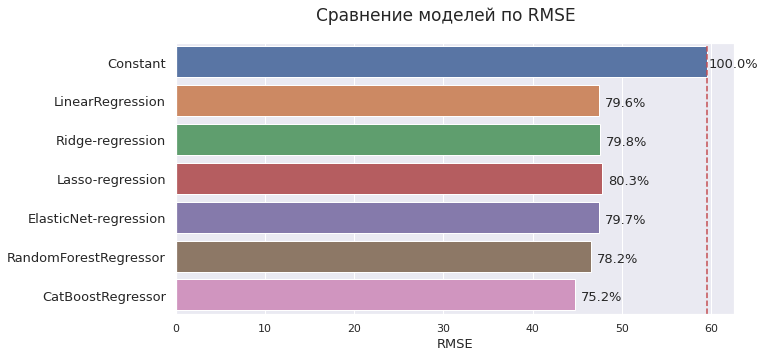

In [83]:
# сравнение метрик различных моделей по метрике RMSE с помощью функции algo_comparison()
algo_comparison(
    result_df['rmse_values'],
    result_df.index,
    'Сравнение моделей по RMSE',
    'RMSE',
    result_df.loc['Constant', 'rmse_values']
)

Для лучшего понимая того, в каких случаях лучшая модель на основе CatBoostRegressor чаще ошибается, а в каких прогнозы получаются лучше, совместим на одном графике предсказанные и реальные количества заказов такси за час. Для этого объединим в датафрейме реальные значения целевой переменной с её предсказанными значениями.

In [84]:
# создание датафрейма, объединяющего предсказанные и реальные значения целевой переменной
df_preds = pd.concat([y_test, pd.Series(model_cb.predict(x_test), index = y_test.index, name='preds')], axis=1)

In [85]:
# просмотр первых строк полученного датафрейма
df_preds.head(10)

,num_orders,preds
datetime,,
2018-08-16 00:00:00,202,186.931727
2018-08-16 01:00:00,185,148.319515
2018-08-16 02:00:00,187,175.262157
2018-08-16 03:00:00,166,159.521734
2018-08-16 04:00:00,185,142.921711
2018-08-16 05:00:00,121,70.297217
2018-08-16 06:00:00,35,41.932504
2018-08-16 07:00:00,32,41.868638
2018-08-16 08:00:00,120,95.575248


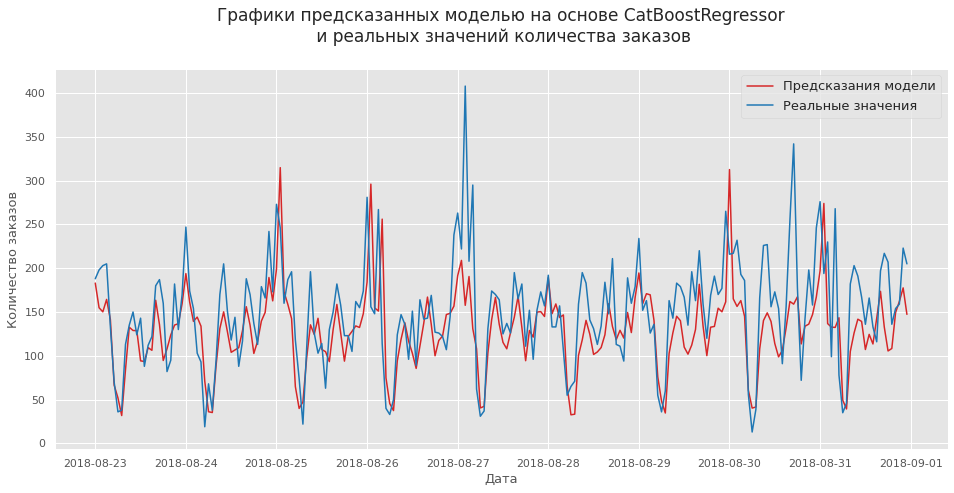

In [86]:
# построение графика зависимости предсказанных и реальных значений количества заказов такси
print()

plt.figure(figsize=(16, 7))
plt.style.use('ggplot')
data = df_preds['2018-08-23':]

sns.lineplot(x=data.index, y=data['preds'], label='Predictions', color='#D62728')
sns.lineplot(x=data.index, y=data['num_orders'], label='True', color='#1F77B4')

plt.title('Графики предсказанных моделью на основе CatBoostRegressor\n и реальных значений количества заказов\n', 
          fontsize=17)
plt.xlabel('Дата', fontsize=13)
plt.ylabel('Количество заказов', fontsize=13)
plt.legend(['Предсказания модели', 'Реальные значения'], fontsize=13)

plt.show();

Также полезно посмотреть на наиболее значимые с точки зрения модели признаки. Для их представления в виде графика создадим вспомогательную функцию *print_feature_importance()*.

In [87]:
# функция печати графика значимости обучающих признаков
def print_feature_importance(importances, feature_id):
    """
    input: importances (pandas.Series)  - показатели значимости признаков
           feature_id (pandas.indexes)  - наименования признаков
    output: None
    description: Функция принимает input параметры и строит горизонтальную столбчатую диаграмму по значениям 
                 относительной важности признаков по отношению к самому важному признаку
    """
    print()
    rel_importance = np.abs(100 * (importances / max(importances)))
    
    rel_feature_df = pd.DataFrame(
        {
            'features' : list(feature_id),
            'rel_importance' : rel_importance
        }
    )

    rel_feature_df = rel_feature_df.sort_values('rel_importance', ascending=False)[:10]
    
    sns.set()
    sns.set_palette(palette='deep')
    fig = plt.figure(figsize=(14, 8))
    fig.suptitle('Относительная значимость признаков модели\n на основе CatBoostRegressor', fontsize=17)

    ax = sns.barplot(data=rel_feature_df, x='rel_importance', y='features', palette='tab20')
    
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/rel_feature_df['rel_importance'].max())
        x = p.get_width()
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x+3, y-0.25), ha='center', fontsize=14)

    plt.ylabel('Признаки', fontsize=14)
    plt.xlabel('Относительная значимость, %', fontsize=14)
    plt.xticks(np.linspace(0, 100, 11), fontsize=12)
    ax.set_yticklabels(rel_feature_df['features'].values, size=13)
    plt.show();
    
    return None

Вызовем функцию *print_feature_importance()* передав ей в качестве аргументов показатели значимости признаков, а также их наименования, полученные из обученной модели *CatBoostRegressor* и отобразим 10 наиболее значимых с точки зрения модели признаков.

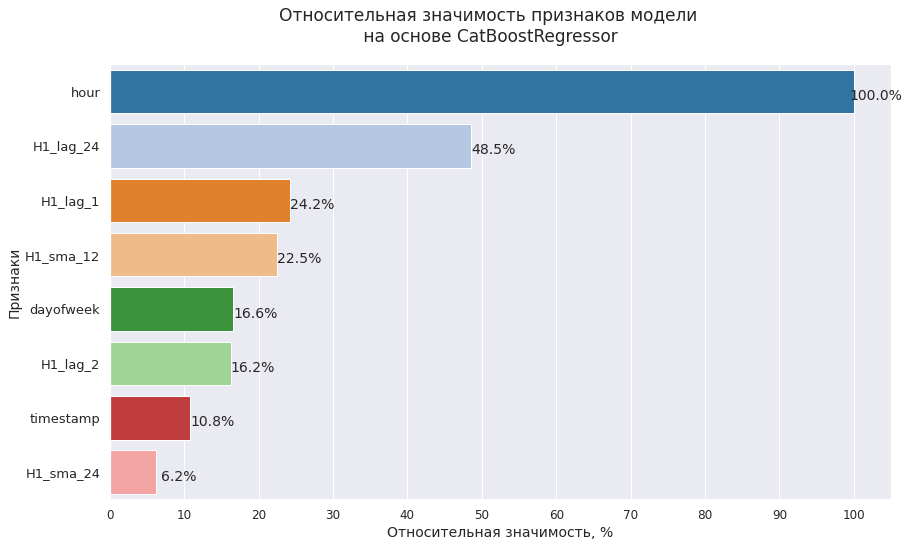

In [88]:
# получение списка признаков и степени из значимости, а также построение графика относительной значимости признаков
df_importance = model_cb.get_feature_importance(prettified=True)

print_feature_importance(df_importance['Importances'], df_importance['Feature Id'])

> * Наиболее значимым атрибутом в признаковом пространстве с точки зрения результатов обученной модели на основе *CatBoostRegressor* является значение текущего часа `hours`, что интиутивно достаточно очевидно, так как именно в зависимости от времени суток происходят основные колебания количества заказов в такси. Следующие три места занимают искуственно созданные на основе `1` и `24` смещений признаки, а также признак в виде значений скольщей средней с периодом `12`. На пятом месте номер дня недели `dayofweek`.

### Выводы по обучению моделей

> * На основе объединённого датасета сформированы обучающая и тестовая выборки в соотношении 9:1.
> * В качестве метрики для оптимизации определена функция нахождения среднеквадратичной ошибки *RMSE*.
> * За константную модель приняты значения количества заказов предыдущего часа, для чего получены «предсказания» смещением данных на один час вперёд и для данной модели определено *RMSE*, которое составило `≈59.5`.
> * Проведено обучение 6 видов различных моделей машинного обучения:
>  - Линейной регрессии
>  - *Ridge*-регрессии
>  - *Lasso*-регрессии
>  - *ElasticNet*-регрессии
>  - Cлучайного леса
>  - *CatBoostRegressor*
> * Наилучший результат со значением метрики *RMSE*, равным `≈44.7`, продемонстрировала модель на основе *CatBoostRegressor*.
> * Все модели на основе линейных моделей показали очень похожие результаты со значением метрики *RMSE*, в диапазоне `≈47.4-47.8`.
> * Модель на основе случайного леса обеспечила получение значения метрики *RMSE*, равного `≈46.5`, что лучше моделей на основе линейных алгоритмов, но хуже модели на основе *CatBoostRegressor*.
> * По графику предсказанных и реальных значений количества заказов такси видно, что модель пытается повторить периодические колебания целевой переменной. Достаточно точно прогнозируются отклонения в область минимальных значений, что говорит об их систематичности и высокой степени прогнозируемости. Хуже модель справляется с пиковыми выбросами в область максимальных значений. Причины появления подобный выбросов нуждаются в дополнительном исследовании. Это могут быть внешние факторы, которые модель не может учесть, пока они не будут в неё добавлены. Подобными факторами могут быть, к примеру, ухудшение погодных условий, или проведение культурно-массового мероприятия, из-за чего спрос на услуги такси резко возрастает.
> * Наиболее значимым атрибутом в признаковом пространстве с точки зрения результатов обученной модели на основе *CatBoostRegressor* является значение текущего часа `hours`, что интиутивно достаточно очевидно, так как именно в зависимости от времени суток происходят основные колебания количества заказов в такси. Следующие три места занимают искуственно созданные на основе `1` и `24` смещений признаки, а также признак в виде значений скольщей средней с периодом `12`. На пятом месте номер дня недели `dayofweek`.

## Общие выводы

> 1. Полученные в файлe `taxi.csv` исходные данные о количестве заказов в такси загружены и проанализированы:
>    * в полученных данных содержится  `26495` записей без пропущенных значений и дубликатов;
>    * данные состоят из двух признаков: даты/времени `datetime` и количества заказов на это время `num_orders`;
>    * изначально данные разбиты на 10-минутные промежутки и охватывают период с `1 марта 2018 года` по `31 августа 2018` года (`6` месяцев);
>    * для работы с данными как с времеными рядами в качестве индексов назначен признак времени, данные проверены на монотонность и отсортированы по возрастанию;
>    * в соотвествии с уловиями задания проведено семплирования данных к 1-часовому временному промежутку в результате которого количество данных сократилось с `26496` записей до `4416` (в `6` раз);
>    * данные разделены на обучающую и тестовую выборки без перемешивания (тестовые данные находятся в конце рассматриваемого периода), согласно требований к заданию для тестирования выделено `10%` от общего количества данных.
>
>
> 2. Проведён анализ обучающей выборки и подготовка данных:
>    * данные с часовым периодом `H1` дополнительно семплированы для получения временного ряда с дневной периодичностью;
>    * для графика каждого периода (`H1` и `D1`) проведена декомпозиция данных на трендовую, сезонную составляющие и остатки по результатам которой определён перечень дополнительных признаков, которые будут добавлены к данным;
>    * на основе данных часовых и дневных периодов созданы дополнительные признаки, которые представляют собой ближайшие предыдущие значения и значения скользящих средних различной периодичности, полученных на основе данных часового периода;
>    * сформирован датасет с дополнительными признаками, в котором собраны приведённые к единой размерности данные по часовым и дневным периодам;
>    * в полученном объединённом датасете кроме целевого признака `num_orders` содержатся два категориальных целочисленных признака в виде дня недели `dayofweek` и часа `hour`, остальные признаки количественные образованы вещественными числами.
>
>
> 3. Выполнено обучение моделей, определяющих количество заказов такси на следующий час, и проведён их сравнительный анализ:
>    * на основе объединённого датасета сформированы обучающая и тестовая выборки в соотношении 9:1;
>    * в качестве метрики для оптимизации определена функция нахождения среднеквадратичной ошибки *RMSE*;
>    * за константную модель приняты значения количества заказов предыдущего часа, для чего получены «предсказания» смещением данных на один час вперёд и для данной модели определено *RMSE*, которое составило `≈59.5`;
>        * Проведено обучение 6 видов различных моделей машинного обучения:
>        * Линейной регрессии
>        * *Ridge*-регрессии
>        * *Lasso*-регрессии
>        * *ElasticNet*-регрессии
>        * Cлучайного леса
>        * *CatBoostRegressor*
>    * наилучший результат со значением метрики *RMSE*, равным `≈44.7`, продемонстрировала модель на основе *CatBoostRegressor*;
>    * все модели на основе линейных моделей показали очень похожие результаты со значением метрики *RMSE*, в диапазоне `≈47.4-47.8`;
>    * модель на основе случайного леса обеспечила получение значения метрики *RMSE*, равного `≈46.5`, что лучше моделей на основе линейных алгоритмов, но хуже модели на основе *CatBoostRegressor*;
>    * обученная модель на основе *CatBoostRegressor* достаточно точно повторяет периодические колебания целевой переменной и заметно хуже справляется с пиковыми выбросами в область максимальных значений для улучшения прогнозирования которых необходимо взаимодействие с бизнесом с целью установления причин, которые формируют эти выбросы;
>    * наиболее значимыми атрибутами в признаковом пространстве с точки зрения результатов обученной модели на основе *CatBoostRegressor* определены значение текущего часа `hours`, созданные на основе смещений различной величины от часового периода показатели, а также номер дня недели `dayofweek`;
>    * сравнительный анализ всех обученных моделей (кроме константной) показал, что указанное сочетание признаков позволило выполнить условие задания `RMSE < 48` всеми рассмотренными моделями.